# Final Exam/Project -- Applied Machine Learning

Josh Gregory

## Algorithm Selection

The first classification algorithm that will be used is an SVM. The second will be a convolutional neural network (CNN).

I am going to implement $k$-fold cross-validation, and as such, will be combining the given dataset splits into one dataset.

## SVM Implementation

### Pre-Processing

Unlike CNNs, SVMs cannot take in raw image data. Therefore, we will need to pre-process the data into tensors manually before feeding it into the SVM.

In [5]:
from IPython.display import Image
%matplotlib inline

#importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import tree, preprocessing
import seaborn as sns
sns.set()
import os
# from skimage import io, transform
from sklearn.utils import shuffle

In [6]:
import cv2

def pre_process_images(data_directory):
    features = []
    labels = []

    for color in ['red', 'yellow', 'green']:
        color_path = os.path.join(data_directory, color)

        # Get all files in color directory

        for file in os.listdir(color_path):
            img_path = os.path.join(color_path, file)
                
            # Read in image
            img = mpimg.imread(img_path)

            image_crop = np.copy(img)
            row_crop = 7
            col_crop = 8
            image_crop = img[row_crop:-row_crop, col_crop:-col_crop, :]

            img_resized = cv2.resize(image_crop, (32, 32))

            # Resize image
            # img_resized = transform.resize(img, (32, 32))

            # Flatten image
            flat_features = img_resized.flatten()
            features.append(flat_features)

            # Append the label as well
            labels.append(color)

    features = np.array(features)

    # Convert strings of colors to integer values
    light_dict = {'red': 0, 'yellow': 1, 'green': 2}
    labels = np.array([light_dict[label] for label in labels])
    features, labels = shuffle(features, labels, random_state=42)

    return features, labels
    

In [9]:
# Prepare training data

X, y = pre_process_images('traffic_light_images_shah/data/')

print(y)

[0 0 2 ... 0 2 2]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
from sklearn.model_selection import GridSearchCV

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.svm import SVC

from sklearn.model_selection import learning_curve

from sklearn.pipeline import make_pipeline

from sklearn.pipeline import Pipeline

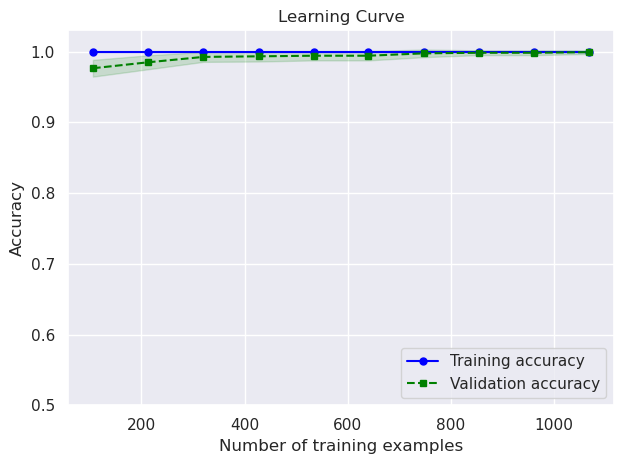

In [18]:
pipe_svc = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_svc,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

#print(train_sizes)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Learning Curve")
plt.ylim([0.5, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

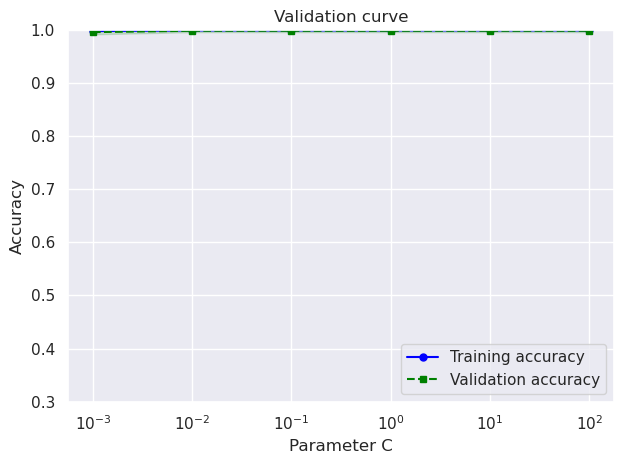

In [19]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_svc, 
                X=X_train, 
                y=y_train, 
                param_name='svc__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid(True)
plt.xscale('log')
plt.title('Validation curve')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()